<a href="https://colab.research.google.com/github/Anshad-Aziz/technical-training/blob/main/Case_study_crop_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import set_config
set_config(display='diagram')
import tqdm
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

In [4]:
crop_production_df=pd.read_csv('crop_production_data.csv')
water_usage_df=pd.read_csv('water_usage_data.csv')
soil_analysis_df=pd.read_csv('soil_analysis_data.csv')
crop_price_df=pd.read_csv('crop_price_data.csv')

In [5]:
merged_df=crop_production_df.merge(water_usage_df,on=['District','Crop'])
merged_df=merged_df.merge(soil_analysis_df,on=['District'])
merged_df=merged_df.merge(crop_price_df,on=['District','Crop'])

In [6]:
merged_df.drop(['District','Crop','Market','Date'],axis=1,inplace=True)

In [7]:
merged_df.drop_duplicates(inplace=True)

In [8]:
merged_df

,Season,Area (hectares),Yield (quintals),Production (metric tons),Irrigation Method,Water Consumption (liters/hectare),Water Availability (liters/hectare),Soil Type,pH Level,Organic Matter (%),Nitrogen Content (kg/ha),Phosphorus Content (kg/ha),Potassium Content (kg/ha),Price (INR/quintal)
0,Kharif,16490.142459,30.691986,5061.152230,Sprinkler Irrigation,9738.809833,10557.488279,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,2594.820361
1,Kharif,16490.142459,30.691986,5061.152230,Sprinkler Irrigation,9738.809833,10557.488279,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,2947.041257
2,Kharif,16490.142459,30.691986,5061.152230,Sprinkler Irrigation,9738.809833,10557.488279,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,2820.399333
3,Kharif,16490.142459,30.691986,5061.152230,Sprinkler Irrigation,9738.809833,10557.488279,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,1969.582984
4,Kharif,16490.142459,30.691986,5061.152230,Sprinkler Irrigation,9738.809833,10557.488279,Sandy,7.453182,2.662898,23.564182,13.014409,37.082003,2687.057740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9055247,Kharif,16967.702330,42.402728,7194.768632,Drip Irrigation,11927.850413,11650.678989,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,2267.719023
9055248,Kharif,16967.702330,42.402728,7194.768632,Drip Irrigation,11927.850413,11650.678989,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,2966.284732
9055249,Kharif,16967.702330,42.402728,7194.768632,Drip Irrigation,11927.850413,11650.678989,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,2428.806330
9055250,Kharif,16967.702330,42.402728,7194.768632,Drip Irrigation,11927.850413,11650.678989,Chalky (Calcareous),7.079614,2.110315,28.239561,21.623791,42.902838,2749.883633


In [9]:
X=merged_df.drop('Price (INR/quintal)',axis=1)
y=merged_df['Price (INR/quintal)']

In [10]:
merged_df.describe()

,Area (hectares),Yield (quintals),Production (metric tons),Water Consumption (liters/hectare),Water Availability (liters/hectare),pH Level,Organic Matter (%),Nitrogen Content (kg/ha),Phosphorus Content (kg/ha),Potassium Content (kg/ha),Price (INR/quintal)
count,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06,9.055252e+06
mean,1.508939e+04,3.767617e+01,5.685255e+03,1.050657e+04,1.048652e+04,7.497677e+00,1.992364e+00,2.989825e+01,1.973011e+01,3.989671e+01,2.500472e+03
std,2.781033e+03,8.270271e+00,1.638171e+03,2.848033e+03,2.925668e+03,5.149368e-01,5.176657e-01,5.193390e+00,5.054560e+00,4.862475e+00,2.969981e+02
min,5.276198e+03,2.027294e+01,1.728446e+03,4.673530e+03,4.505257e+03,5.889492e+00,1.558174e-01,1.199457e+01,4.961838e+00,2.411648e+01,1.323280e+03
25%,1.318315e+04,3.101229e+01,4.491575e+03,8.163200e+03,8.109719e+03,7.159913e+00,1.632442e+00,2.622104e+01,1.620515e+01,3.671655e+01,2.302458e+03
50%,1.518069e+04,3.719335e+01,5.571835e+03,1.029296e+04,1.038500e+04,7.506250e+00,1.979354e+00,2.986308e+01,1.992951e+01,3.980629e+01,2.501839e+03
75%,1.703378e+04,4.401697e+01,6.766723e+03,1.271125e+04,1.291489e+04,7.847932e+00,2.350350e+00,3.326165e+01,2.309869e+01,4.340110e+01,2.702029e+03
max,2.000000e+04,6.042919e+01,1.083453e+04,1.863109e+04,1.848917e+04,9.038430e+00,3.764528e+00,4.576028e+01,3.558841e+01,5.467829e+01,3.513330e+03


<ipython-input-11-c0df8c31d068>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(merged_df.corr(),annot=True,cmap='coolwarm')


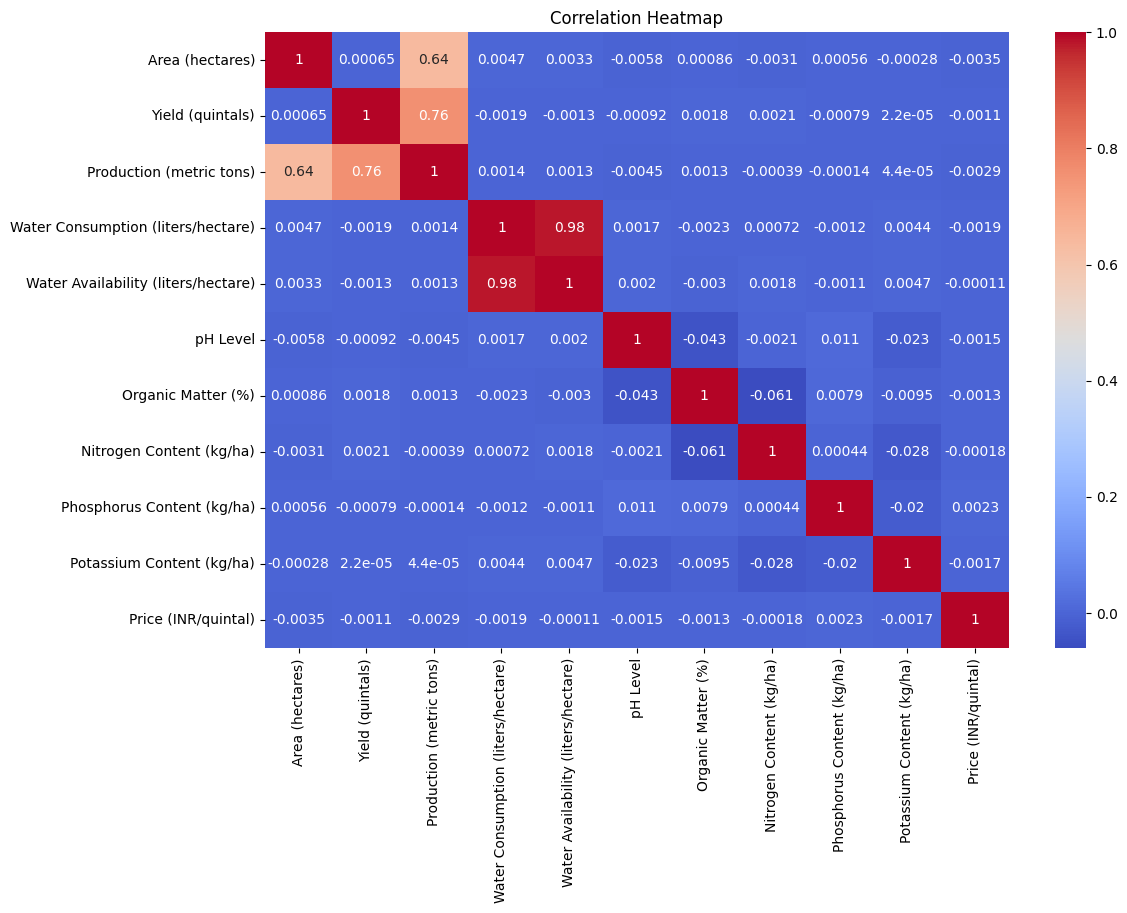

In [11]:
plt.figure(figsize=(12,8))
sns.heatmap(merged_df.corr(),annot=True,cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [12]:
top_correlated_features=merged_df.corr()['Price (INR/quintal)'].sort_values(ascending=False)[1:4].index.tolist()
print("top correlation features with crop prices:")
for feature in top_correlated_features:
  print("-",feature)

<ipython-input-12-82f4752d56ea>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  top_correlated_features=merged_df.corr()['Price (INR/quintal)'].sort_values(ascending=False)[1:4].index.tolist()


top correlation features with crop prices:
- Phosphorus Content (kg/ha)
- Water Availability (liters/hectare)
- Nitrogen Content (kg/ha)


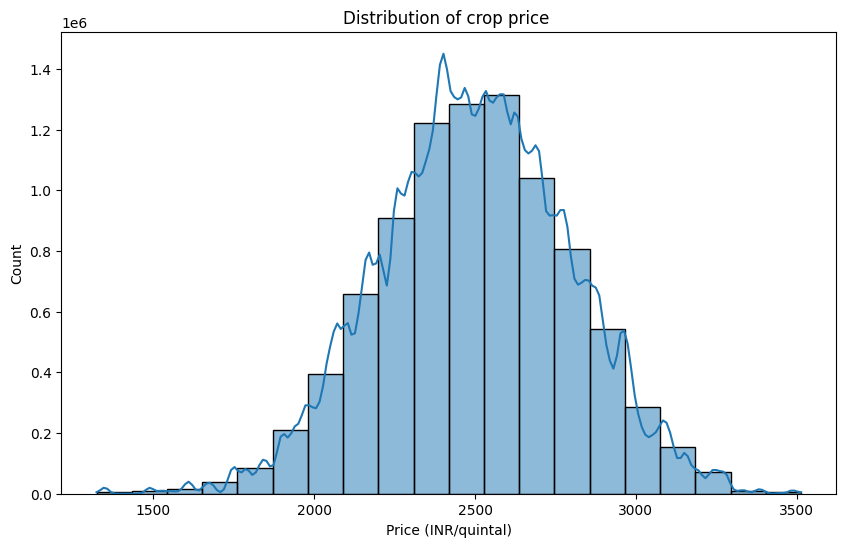

In [13]:
plt.figure(figsize=(10,6))
sns.histplot(data=merged_df,x='Price (INR/quintal)',bins=20,kde=True)
plt.title('Distribution of crop price ')
plt.xlabel('Price (INR/quintal)')
plt.ylabel('Count')
plt.show()

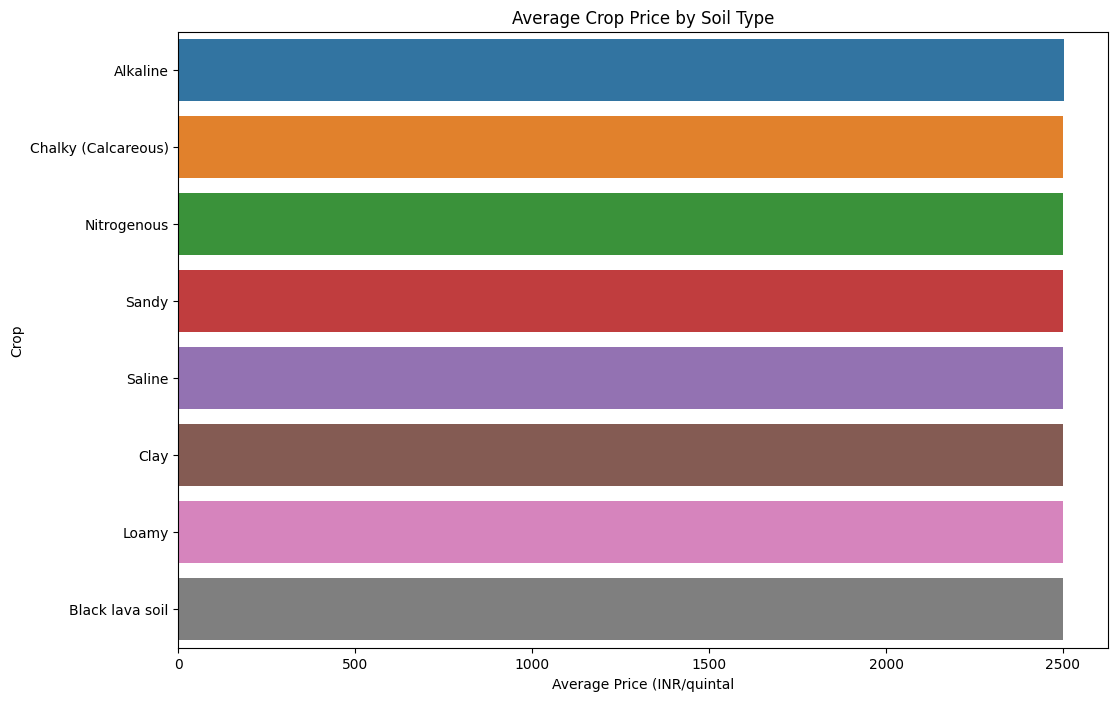

In [14]:
average_prices=merged_df.groupby('Soil Type')['Price (INR/quintal)'].mean().sort_values(ascending=False)
plt.figure(figsize=(12,8))
sns.barplot(x=average_prices.values,y=average_prices.index)
plt.title('Average Crop Price by Soil Type')
plt.xlabel('Average Price (INR/quintal')
plt.ylabel('Crop')
plt.show()

In [15]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [16]:
categorical_columns=['Season','Soil Type','Irrigation Method']

preprocessor=ColumnTransformer(
    transformers=[('encoder',OneHotEncoder(),categorical_columns)],
    remainder='passthrough'
)

In [17]:
X_train_encoded=preprocessor.fit_transform(X_train)

In [20]:
pipline=Pipeline([
    ('scaler',StandardScaler()),
    ('regressor',RandomForestRegressor(random_state=42))
])

In [21]:
param_grid={
    'regressor__n_estimators':[100,200,300],
    'regressor__max_depth':[None,5,10],
    'regressor__min_samples_split':[2,5,10]
}

In [ ]:
grid_search=GridSearchCV(pipline,param_grid,cv=5,scoring='neg_mean_squared_error',n_jobs=-1,verbose=3)
grid_search.fit(X_train_encoded,y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
